# EXPLORATORY DATA ANALYSIS

## Packages and Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

2024-11-09 21:45:10.262209: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 21:45:10.536456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 21:45:10.636244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-09 21:45:10.661112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 21:45:10.837200: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Load your data (replace these with actual paths or data loading methods)
x_train = pd.read_csv('data/tox21_dense_train.csv')
y_train = pd.read_csv('data/tox21_labels_train.csv')

# Preprocessing
compound_ids = x_train['Unnamed: 0']
x_train = x_train.drop(columns=['Unnamed: 0'])
y_train = y_train.drop(columns=['Unnamed: 0'])

# Create masks based on valid labels in y_train
y_train_mask = ~y_train.isna()
y_train = y_train.fillna(0)  # Replace NaNs with zeros for computation

# Model Parameters
num_features = x_train.shape[1]
num_tasks = y_train.shape[1]
num_hidden_units = 1024  # Adjust based on resources
dropout_rate = 0.5
learning_rate = 0.001

# TensorFlow Model
class ToxicityPredictionModel(tf.keras.Model):
    def __init__(self, num_features, num_tasks, num_hidden_units, dropout_rate):
        super(ToxicityPredictionModel, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(num_hidden_units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_layers = [tf.keras.layers.Dense(1, activation='sigmoid') for _ in range(num_tasks)]
    
    def call(self, inputs, training=False):
        x = self.hidden_layer(inputs)
        x = self.dropout(x, training=training)
        return [layer(x) for layer in self.output_layers]

# Instantiate the model
model = ToxicityPredictionModel(num_features, num_tasks, num_hidden_units, dropout_rate)

# Custom Loss Function with Masked Weighted Binary Cross-Entropy
def masked_loss(y_true, y_pred, mask):
    loss = 0
    for task_idx in range(num_tasks):
        y_t = y_true[:, task_idx]
        y_p = y_pred[task_idx]
        m = tf.cast(mask[:, task_idx], tf.float32)
        
        # Binary cross-entropy for each task with masking
        bce = tf.keras.losses.binary_crossentropy(y_t, y_p)
        masked_bce = tf.multiply(bce, m)
        
        # Accumulate weighted loss for each task
        task_loss = tf.reduce_sum(masked_bce) / tf.reduce_sum(m + 1e-10)
        loss += task_loss
    return loss / num_tasks

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=lambda y_true, y_pred: masked_loss(y_true, y_pred, y_train_mask.values))

# Training the model
x_train_np = x_train.values
y_train_np = y_train.values

# Fit model
history = model.fit(x_train_np, y_train_np, epochs=50, batch_size=64, verbose=1)

# Model Evaluation
# Use similar masked loss or AUC for evaluation if applicable


I0000 00:00:1731217553.933120    3860 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-09 21:45:54.086104: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50


/home/qamil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 1.4319
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8190
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.8462
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8108
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8181
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.8526
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8394
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.8433
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8040
Epoch 10/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8437
Epoch 11/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.8162
Epoch 12/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8162
Epoch 13/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.8325
Epoch 14/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8408
Epoch 15/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step 

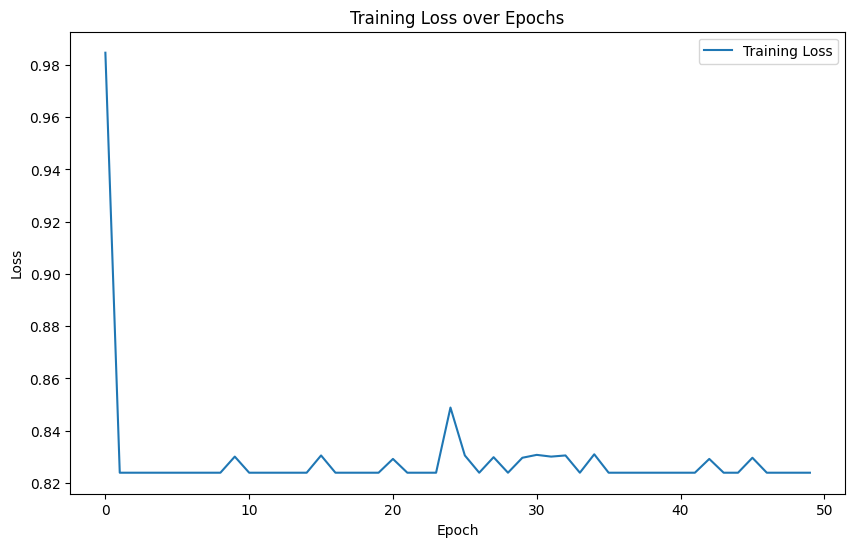

In [3]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Task-wise loss (optional): assumes model outputs task-wise loss components
# Uncomment if you have task-wise history saved in history
# for i in range(num_tasks):
#     plt.figure(figsize=(10, 6))
#     plt.plot(history.history[f'task_{i}_loss'], label=f'Task {i} Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel(f'Task {i} Loss')
#     plt.title(f'Task {i} Loss over Epochs')
#     plt.legend()
#     plt.show()


## Data Analysis

In [2]:
# Train and test data from Tox21 dataset
x_train = pd.read_csv('data/tox21_dense_train.csv')
y_train = pd.read_csv('data/tox21_labels_train.csv')

x_test = pd.read_csv('data/tox21_dense_test.csv')
y_test = pd.read_csv('data/tox21_labels_test.csv')

In [3]:
x_train.head()

,Unnamed: 0,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
0,NCGC00178831-03,5.436720e+07,13.053,2.176,3.194,23.112,15.868,1.496,15.127,12.592,...,2687.469,9241.018,115.371,-915.496,-39.983,290.078,2301.941,59.492,88.147,3.708
1,NCGC00166114-03,1.268818e+07,22.123,2.065,3.137,21.033,13.718,1.937,13.187,11.951,...,2184.384,3234.199,194.740,-1029.609,-34.205,235.360,1244.323,82.906,134.852,4.131
2,NCGC00263563-01,3.076932e+06,13.085,2.154,3.207,46.896,29.958,3.806,30.105,25.569,...,13803.524,76582.899,238.004,-4358.946,-106.537,868.685,15909.444,135.335,216.852,5.075
3,NCGC00013058-02,7.168569e+07,12.832,2.029,3.380,51.086,32.045,1.806,29.090,21.603,...,13807.345,50498.175,226.312,-2785.555,-61.923,763.288,9394.859,125.509,238.265,4.640
4,NCGC00167516-01,7.989702e+06,12.936,2.124,3.573,70.295,46.402,3.604,42.132,32.570,...,43231.286,163659.229,850.869,-21136.699,-367.122,1798.703,44681.209,362.168,317.901,7.845


In [4]:
# Check out the data
x_train.head()

print(f"(n_samples, d_features): {x_train.shape}")
print(f"{x_train.columns}")

(n_samples, d_features): (12060, 802)
Index(['Unnamed: 0', 'AW', 'AWeight', 'Arto', 'BertzCT', 'Chi0', 'Chi1',
       'Chi10', 'Chi2', 'Chi3',
       ...
       'W3D', 'W3DH', 'WNSA1', 'WNSA2', 'WNSA3', 'WPSA1', 'WPSA2', 'WPSA3',
       'grav', 'rygr'],
      dtype='object', length=802)


In [5]:
y_train.head()

print(f"(n_samples, m_tasks): {y_train.shape}")
print(f"{y_train.columns}")

(n_samples, m_tasks): (12060, 13)
Index(['Unnamed: 0', 'NR.AhR', 'NR.AR', 'NR.AR.LBD', 'NR.Aromatase', 'NR.ER',
       'NR.ER.LBD', 'NR.PPAR.gamma', 'SR.ARE', 'SR.ATAD5', 'SR.HSE', 'SR.MMP',
       'SR.p53'],
      dtype='object')


In [6]:
# Check missing values
print(f"Missing values in x_train: {x_train.isnull().sum().sum()}")
print(f"Missing values in y_train: {y_train.isnull().sum().sum()}")

# Check for missing values in test data
print(f"Missing values in x_test: {x_test.isnull().sum().sum()}")
print(f"Missing values in y_test: {y_test.isnull().sum().sum()}")

Missing values in x_train: 0
Missing values in y_train: 43238
Missing values in x_test: 0
Missing values in y_test: 791


In [7]:
x_train.describe()

,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,Chi3c,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
count,1.206000e+04,12060.000000,12060.000000,12060.000000,12060.000000,12060.00000,12060.000000,12060.000000,12060.000000,12060.000000,...,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000
mean,4.219191e+06,14.510179,2.011927,2.546282,14.001534,9.01234,0.522415,8.201283,6.307590,1.600608,...,1248.363297,5293.483884,85.805640,-555.791432,-30.399123,186.128018,1238.731087,34.164007,123.783499,3.219006
std,1.175669e+07,4.787198,0.195923,0.435071,8.091058,5.32414,0.826746,5.153103,4.387759,1.331670,...,3180.775783,12823.738015,72.904885,1918.257248,36.252950,165.551810,3232.420359,33.984633,3842.918796,0.994193
min,1.000000e+00,11.366000,0.000000,0.301000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.206000,1.688000,0.000000,-120941.468000,-1235.074000,0.000000,0.000000,0.000000,1.594000,0.162000
25%,3.077000e+00,12.723000,1.941000,2.323000,8.552000,5.34300,0.000000,4.767000,3.288000,0.731000,...,203.316750,915.805250,43.300500,-544.346750,-36.667000,89.507000,236.484250,16.736500,21.649000,2.530000
50%,4.199000e+00,13.342000,2.000000,2.631000,12.466000,8.04100,0.217000,7.223000,5.439000,1.280000,...,550.826000,2236.311500,69.967500,-261.439000,-22.159000,146.220000,561.240000,26.911500,36.319500,3.142000
75%,6.609000e+00,14.583000,2.138000,2.853000,17.225250,11.30725,0.706000,10.426500,8.433500,2.070000,...,1290.369250,5515.172000,107.567750,-112.989250,-13.248500,234.616500,1259.678750,41.569000,57.437250,3.746000
max,1.000000e+08,151.466000,2.667000,3.776000,94.695000,63.00600,12.188000,59.172000,50.798000,19.852000,...,93581.972000,355470.488000,1366.650000,0.000000,0.000000,3353.749000,101675.928000,1391.785000,397154.560000,15.511000


## Feature Scaling

In [8]:
# Standard Deviation
std_scaler = StandardScaler()

# Fit the scaler on the training data
std_scaler.fit_transform(x_train.iloc[:, 1:])

print(x_train.describe())

                 AW       AWeight          Arto       BertzCT          Chi0  \
count  1.206000e+04  12060.000000  12060.000000  12060.000000  12060.000000   
mean   4.219191e+06     14.510179      2.011927      2.546282     14.001534   
std    1.175669e+07      4.787198      0.195923      0.435071      8.091058   
min    1.000000e+00     11.366000      0.000000      0.301000      0.000000   
25%    3.077000e+00     12.723000      1.941000      2.323000      8.552000   
50%    4.199000e+00     13.342000      2.000000      2.631000     12.466000   
75%    6.609000e+00     14.583000      2.138000      2.853000     17.225250   
max    1.000000e+08    151.466000      2.667000      3.776000     94.695000   

              Chi1         Chi10          Chi2          Chi3         Chi3c  \
count  12060.00000  12060.000000  12060.000000  12060.000000  12060.000000   
mean       9.01234      0.522415      8.201283      6.307590      1.600608   
std        5.32414      0.826746      5.153103      4.

In [9]:
x_train.head()

,Unnamed: 0,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
0,NCGC00178831-03,5.436720e+07,13.053,2.176,3.194,23.112,15.868,1.496,15.127,12.592,...,2687.469,9241.018,115.371,-915.496,-39.983,290.078,2301.941,59.492,88.147,3.708
1,NCGC00166114-03,1.268818e+07,22.123,2.065,3.137,21.033,13.718,1.937,13.187,11.951,...,2184.384,3234.199,194.740,-1029.609,-34.205,235.360,1244.323,82.906,134.852,4.131
2,NCGC00263563-01,3.076932e+06,13.085,2.154,3.207,46.896,29.958,3.806,30.105,25.569,...,13803.524,76582.899,238.004,-4358.946,-106.537,868.685,15909.444,135.335,216.852,5.075
3,NCGC00013058-02,7.168569e+07,12.832,2.029,3.380,51.086,32.045,1.806,29.090,21.603,...,13807.345,50498.175,226.312,-2785.555,-61.923,763.288,9394.859,125.509,238.265,4.640
4,NCGC00167516-01,7.989702e+06,12.936,2.124,3.573,70.295,46.402,3.604,42.132,32.570,...,43231.286,163659.229,850.869,-21136.699,-367.122,1798.703,44681.209,362.168,317.901,7.845


## Create Masks for Loss evaluation
The masks below {add explanation}

In [ ]:
y_train_mask = ~y_train.isna()
print(y_train_mask)

       Unnamed: 0  NR.AhR  NR.AR  NR.AR.LBD  NR.Aromatase  NR.ER  NR.ER.LBD  \
0            True   False  False      False         False  False      False   
1            True   False  False      False         False  False      False   
2            True   False  False      False         False  False      False   
3            True   False  False      False         False  False      False   
4            True   False   True      False         False  False      False   
...           ...     ...    ...        ...           ...    ...        ...   
12055        True    True   True       True          True   True       True   
12056        True    True   True       True         False  False       True   
12057        True    True   True       True          True   True       True   
12058        True    True   True       True          True   True       True   
12059        True    True   True       True          True  False       True   

       NR.PPAR.gamma  SR.ARE  SR.ATAD5  SR.HSE  SR.

## Defining The Model

In [48]:
def create_multitask_model(input_dim, num_tasks, hidden_units=1024, num_layers=2, dropout_rate=0.5, 
                           input_dropout=0.2, learning_rate=0.01, l2_weight_decay=1e-5, normalization='standard-deviation',
                           loss_function='binary_crossentropy'):
    
    # Normalize input data based on specified normalization
    if normalization == 'standard-deviation':
        scaler = StandardScaler()
    elif normalization == 'tanh':
        # Tanh normalization can be done within the model using a tanh activation layer.
        pass
    elif normalization == 'sqrt':
        pass

    # Input layer
    inputs = Input(shape=(input_dim,))
    
    # Optional input dropout
    x = Dropout(input_dropout)(inputs) if input_dropout > 0 else inputs

    # Shared hidden layers with L2 regularization and dropout
    for _ in range(num_layers):
        x = Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_weight_decay))(x)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)

    # Task-specific output layers
    outputs = []
    for _ in range(num_tasks):
        task_output = Dense(1, activation='sigmoid')(x)
        outputs.append(task_output)

    # Define the model with shared input and multiple task-specific outputs
    model = Model(inputs=inputs, outputs=outputs)
    
    # Define the optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile model with binary cross-entropy loss for each task
    model.compile(optimizer=optimizer, loss=loss_function)
    
    return model

In [49]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [50]:
x_train = x_train.iloc[:, 1:].values
y_train = y_train.iloc[:, 1:].values
y_train_mask = y_train_mask.iloc[:, 1:].values

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [57]:
def masked_binary_crossentropy(y_true, y_pred, mask):
    epsilon = 1e-7  # To avoid log(0)
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)  # Clip y_pred to avoid log(0)
    
    # Calculate cross-entropy loss
    loss = - (y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

    # Ensure mask is float32 to allow for reduction operations
    mask = tf.cast(mask, tf.float32)
    
    # Apply the mask to include only valid entries
    masked_loss = loss * mask
    
    # Normalize by the number of valid (non-masked) entries to get the average loss
    return K.sum(masked_loss) / K.sum(mask)  # Return mean of masked loss


In [58]:
y_train_with_mask = np.concatenate([y_train, y_train_mask], axis=1)

In [59]:
NUM_SAMPLES = x_train.shape[0]
NUM_FEATURES = x_train.shape[1]
NUM_TASKS = y_train.shape[1]

HIDDEN_UNITS = 1024
NUM_LAYERS = 2
DROPOUT_RATE = 0.5
INPUT_DROPOUT = 0.2
LEARNING_RATE = 0.01
L2_WEIGHT_DECAY = 1e-5

In [60]:
model = create_multitask_model(input_dim=NUM_FEATURES, num_tasks=NUM_TASKS, 
                               hidden_units=HIDDEN_UNITS, num_layers=NUM_LAYERS,
                               dropout_rate=DROPOUT_RATE, input_dropout=INPUT_DROPOUT, 
                               learning_rate=LEARNING_RATE, l2_weight_decay=L2_WEIGHT_DECAY, 
                               loss_function=masked_binary_crossentropy)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 801)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 801)       │          0 │ input_layer_7[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 1024)      │    821,248 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 1024)      │          0 │ dense_98[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_99 (Dense)    │ (None, 1024)      │  1,049,600 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 1024)      │          0 │ dense_99[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_101 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_102 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_106 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_108 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_109 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_110 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_111 (Dense)   │ (None, 1)         │      1,025 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,883,148 (7.18 MB)

 Trainable params: 1,883,148 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Number of epochs and batch size
epochs = 10
batch_size = 32

# Start training
# Custom training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        mask_batch = y_train_mask[i:i + batch_size]
        
        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)
            loss = masked_binary_crossentropy(y_batch, y_pred, mask_batch)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        print(f"Batch {i // batch_size + 1}, Loss: {loss.numpy()}")

    print(f"End of Epoch {epoch + 1}, Loss: {loss.numpy()}")


Epoch 1/10


Batch 1, Loss: nan
Batch 2, Loss: nan
Batch 3, Loss: nan
Batch 4, Loss: nan
Batch 5, Loss: nan
Batch 6, Loss: nan
Batch 7, Loss: nan
Batch 8, Loss: nan
Batch 9, Loss: nan
Batch 10, Loss: nan
Batch 11, Loss: nan
Batch 12, Loss: nan
Batch 13, Loss: nan
Batch 14, Loss: nan
Batch 15, Loss: nan
Batch 16, Loss: nan
Batch 17, Loss: nan
Batch 18, Loss: nan
Batch 19, Loss: nan
Batch 20, Loss: nan
Batch 21, Loss: nan
Batch 22, Loss: nan
Batch 23, Loss: nan
Batch 24, Loss: nan
Batch 25, Loss: nan
Batch 26, Loss: nan
Batch 27, Loss: nan
Batch 28, Loss: nan
Batch 29, Loss: nan
Batch 30, Loss: nan
Batch 31, Loss: nan
Batch 32, Loss: nan
Batch 33, Loss: nan
Batch 34, Loss: nan
Batch 35, Loss: nan
Batch 36, Loss: nan
Batch 37, Loss: nan
Batch 38, Loss: nan
Batch 39, Loss: nan
Batch 40, Loss: nan
Batch 41, Loss: nan
Batch 42, Loss: nan
Batch 43, Loss: nan
Batch 44, Loss: nan
Batch 45, Loss: nan
Batch 46, Loss: nan
Batch 47, Loss: nan
Batch 48, Loss: nan
Batch 49, Loss: nan
Batch 50, Loss: nan
Batch 51,

KeyboardInterrupt: 

In [ ]:
y_train_mask.shape

(12060, 12)